In [1]:
import os.path as osp
import matplotlib.pyplot as plt
%matplotlib inline
from math import ceil
import numpy as np
from mtools import load_h5, colors_names
# import os
# os.chdir('..')
# from data.tools import get_polar_vectors
from mtools.plot_preamble import *
from Metrics import compute_absolute_trajectory_error

output = '../output/tpfinal5/flat'
model = 'transposemt3'
exp_no = '2'
data_path = osp.join(output, 'oxiod_h5_1_N', '%s_eval_result_trace_%s_e%s.h5'%(model, 0, exp_no))
tp_eval_result = load_h5(data_path)
print(data_path)

output = '../output/tpfinal4/mtbase_aug'
model = 'transposemt'
exp_no = '1'
data_path = osp.join(output, 'oxiod_h5_1_N', '%s_eval_result_trace_%s_e%s.h5'%(model, 0, exp_no))
mt_eval_result = load_h5(data_path)
print(data_path)

output = '../output/tpfinal5/ionet'
model = 'ionet'
exp_no = '1'
data_path = osp.join(output, 'oxiod_h5_1_N', '%s_eval_result_trace_%s_e%s.h5'%(model, 0, exp_no))
io_eval_result = load_h5(data_path)
print(data_path)

output = '../output/tpfinal5/ronin'
model = 'ronin'
exp_no = '1'
data_path = osp.join(output, 'oxiod_h5_1_N', '%s_eval_result_trace_%s_e%s.h5'%(model, 0, exp_no))
ro_eval_result = load_h5(data_path)
print(data_path)

../output/tpfinal5/flat/oxiod_h5_1_N/transposemt3_eval_result_trace_0_e2.h5
../output/tpfinal4/mtbase_aug/oxiod_h5_1_N/transposemt_eval_result_trace_0_e1.h5
../output/tpfinal5/ionet/oxiod_h5_1_N/ionet_eval_result_trace_0_e1.h5
../output/tpfinal5/ronin/oxiod_h5_1_N/ronin_eval_result_trace_0_e1.h5


In [2]:
colors = colors_names['base']

def plot_curve(results, colors=colors):
    plt.figure()
    for i,rst in enumerate(results):
        plt.plot(range(rst.shape[0]), rst, colors[i])
    plt.show()

def rerange_angle(rad):
    # raw_deg = gt_df[bearing_key].values
    deg = np.rad2deg(rad)%360 # 所有角度限制到[0,360]
    deg[deg>180] = deg[deg>180]-360
    return np.deg2rad(deg)

def reconstruct_traj_psi_rho(init_psi, rho, psi, is_deg=False):
    heading = np.cumsum(psi) + init_psi
    if is_deg:
        heading = np.deg2rad(heading)
    offsets = np.column_stack((rho*np.cos(heading), rho*np.sin(heading)))
    return np.vstack((np.array([[0, 0]]), np.cumsum(offsets, axis=0))), heading

def get_polar_vectors(locations, origin=None, zero_ind=None, is_torch=False, reverse=False, zero_thres=0.1):
    offsets = locations-locations[...,origin,:] if origin is not None else locations
    if reverse:
        offsets = -offsets
    lengths = np.linalg.norm(offsets, axis=-1)
    angles = np.arctan2(offsets[...,1], offsets[...,0])
    if zero_ind is not None:
        zero_vector = locations[...,zero_ind[1],:] - locations[...,zero_ind[0],:]
        zero_angle = np.arctan2(zero_vector[1], zero_vector[0])
        angles = rerange_angle(angles - zero_angle)
    if lengths[-1] < zero_thres:
        angles = np.zeros_like(lengths)
    return zero_angle, np.stack((lengths, angles), axis=1)

def polar_to_offset(polars):
    return np.stack((polars[...,0]*np.cos(polars[...,1]), polars[...,0]*np.sin(polars[...,1])), axis=-1)

def moving_average(x, filter_size, filter_mode='valid', padding_size=0, padding_mode='edge', rc=1):
    filter_kernel = np.ones(filter_size) / filter_size
    padded_signal = np.pad(x, padding_size, mode=padding_mode)
    filtered_signal = np.convolve(padded_signal, filter_kernel, mode=filter_mode)
    if rc==1:
        return filtered_signal
    else:
        return moving_average(filtered_signal, filter_size, filter_mode, padding_size, padding_mode, rc-1)

def reconstruct_traj_psi_rho_dense(init_headings, init_locs, y_p, is_filter=False, w=3, rc=1, aw=5, bw=19):
    if is_filter:
        y_p = np.column_stack((moving_average(y_p[:, 0], aw, padding_size=aw//2, rc=rc), moving_average(y_p[:, 1], aw, padding_size=aw//2, rc=rc)))
    headings = init_headings.copy()
    locs = init_locs.copy()
    loc_list = []
    for i in range(len(y_p)//20):
        window_slice = slice(i*20, (i+1)*20)
        new_headings = headings+y_p[window_slice, 1]
        lengths = y_p[window_slice, 0]
        offsets = polar_to_offset(np.column_stack((lengths, new_headings)))
        new_locs = locs + offsets
        if is_filter:
            locs_new_locs = np.vstack((locs, new_locs))
            filtered_locs = np.column_stack((moving_average(locs_new_locs[:, 0], w, padding_size=w//2, rc=rc), moving_average(locs_new_locs[:, 1], w, padding_size=w//2, rc=rc)))
            filtered_offsets = filtered_locs[20:] - locs
            filtered_headings = np.arctan2(filtered_offsets[...,1], filtered_offsets[...,0])
            headings_diff = filtered_headings[1:] - filtered_headings[:-1]
            cut_indexs = np.where(np.abs(headings_diff)>np.pi)[0]
            for ind in cut_indexs:
                if headings_diff[ind]>0:
                    filtered_headings[ind+1:] -= 2*np.pi
                else:
                    filtered_headings[ind+1:] += 2*np.pi
            filtered_headings = moving_average(filtered_headings, w, padding_size=w//2, rc=rc)
            new_headings = filtered_headings
            new_locs = filtered_locs[20:]
        locs = new_locs
        headings = new_headings
        loc_list.append(locs)
    locs = np.vstack(loc_list)
    if is_filter:
        locs = np.column_stack((moving_average(locs[:, 0], bw, padding_size=bw//2, rc=rc), moving_average(locs[:, 1], aw, padding_size=aw//2, rc=rc)))
    return locs

def eval_tracking(eval_result, i, start_ind = 600, length = 200):
    y = eval_result[f'{i}_y'][start_ind:start_ind+length]
    y_p = eval_result[f'{i}_y_p'][start_ind:start_ind+length]
    l = eval_result[f'{i}_l'][start_ind:start_ind+length]
    h = eval_result[f'{i}_h'][start_ind:start_ind+length]
    # print(start_ind, y.shape, y_p.shape, l.shape, h.shape)
    rec_traj_gt = reconstruct_traj_psi_rho_dense(h[:20], l[0, 200::10], y)
    rec_traj2 = reconstruct_traj_psi_rho_dense(h[:20], l[0, 200::10], y_p, True, 3)
    # plot_trajs([rec_traj_gt, rec_traj2], ['GroundTruth', 'Filtered Prediction'])
    return start_ind, compute_absolute_trajectory_error(rec_traj_gt, rec_traj2)

def eval_tracking_domain(i, eval_result, start_ind=0, step_size=10, length=200):
    y = eval_result[f'{i}_y']
    print(y.shape[0])
    ate_list = []
    for j in range((y.shape[0]-start_ind-length)//step_size):
        cur_ind, (ate, ate_std) = eval_tracking(eval_result, i, start_ind=start_ind+j*step_size, length=length)
        ate_list.append([cur_ind, ate, ate_std])
    return np.array(ate_list)

0.16542601370099388 0.3098574677244264
0.20738539202243542 0.6830961389600668
0.21600824263088247 0.7393995454726873


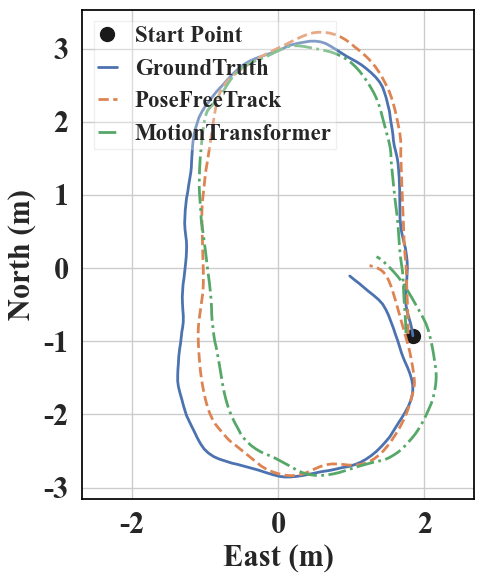

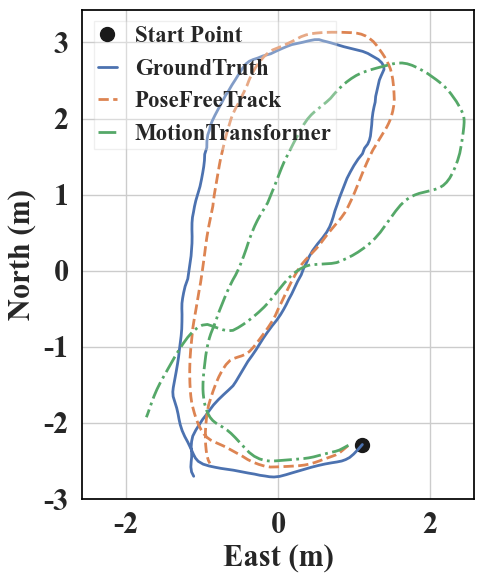

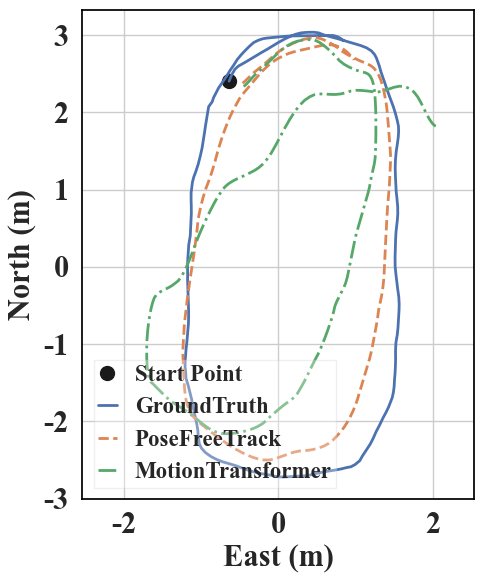

In [16]:
fontsize = 22
is_savefig = True
xlims = [[-4, 4], [-4, 4], [-4, 4]]
linestyles = ['-', '--', '-.']

def plot_trajs(trajs, legends, headings=None, heading_len=0.1, fontsize=18, loc='upper left'):
    fig, ax = plt.subplots(figsize=(5, 6))
    colors = []
    ax.plot(trajs[0][0, 0], trajs[0][0, 1], 'o', color='k', markersize=10, label='Start Point')
    for traj, legend,ls in zip(trajs, legends, linestyles):
        h = ax.plot(traj[:, 0], traj[:, 1], ls, label=legend, markersize=0.1, linewidth=2)
        colors.append(h[0].get_color())
    if headings is not None:
        for traj,heading,color in zip(trajs, headings, colors):
            if heading is not None:
                for x,y,dx,dy in zip(traj[:, 0], traj[:, 1], heading_len*np.cos(heading), heading_len*np.sin(heading)):
                    ax.arrow(x,y,dx,dy, head_width=0.2, facecolor=color, edgecolor='k')
    
    ax.set_xlabel("East (m)", fontsize=fontsize, fontstyle='normal', fontdict={'fontweight':'bold'})
    ax.set_ylabel("North (m)", fontsize=fontsize, fontstyle='normal', fontdict={'fontweight':'bold'})
    
    ax.legend(loc=loc, fontsize=fontsize*0.75, handlelength=0.8, frameon=True, framealpha=0.3, fancybox=False, borderpad=0.2)
    fig.tight_layout()
    return fig, ax

def plot_domain(i, tp_eval_result, mt_eval_result, start_ind = 600, fontsize=28, loc='upper left'):
    end_ind = start_ind+200
    y   = tp_eval_result[f'{i}_y'][start_ind:end_ind]
    y_p = tp_eval_result[f'{i}_y_p'][start_ind:end_ind]
    l   = tp_eval_result[f'{i}_l'][start_ind:end_ind]
    h   = tp_eval_result[f'{i}_h'][start_ind:end_ind]

    rec_traj_gt = reconstruct_traj_psi_rho_dense(h[:20], l[0, 200::10], y)
    rec_traj1 = reconstruct_traj_psi_rho_dense(h[:20], l[0, 200::10], y_p)
    rec_traj2 = reconstruct_traj_psi_rho_dense(h[:20], l[0, 200::10], y_p, True, 3)
    
    y   = mt_eval_result[f'{i}_y'][start_ind:end_ind]
    y_p = mt_eval_result[f'{i}_y_p'][start_ind:end_ind]
    l   = mt_eval_result[f'{i}_l'][start_ind:end_ind]
    h   = mt_eval_result[f'{i}_h'][start_ind:end_ind]

    mt_rec_traj2 = reconstruct_traj_psi_rho_dense(h[:20], l[0, 200::10], y_p, True, 3)

    # plot_trajs([l[:, 200, :], rec_traj_gt, rec_traj1, rec_traj2], ['GroundTruth', 'GroundTruth_R', 'Predicted', 'Predicted Filtered'])
    # plot_trajs([rec_traj_gt, rec_traj2], ['GroundTruth', 'Filtered Prediction'])
    # plot_trajs([rec_traj_gt, rec_traj2, rec_traj1], ['GroundTruth', 'Filtered Prediction', 'Prediction'])
    # plot_trajs([rec_traj2[19::20], rec_traj2[::20]], ['19::20', '0::20'])
    fig, ax = plot_trajs([rec_traj_gt, rec_traj2, mt_rec_traj2], ['GroundTruth', 'PoseFreeTrack', 'MotionTransformer'], fontsize=fontsize, loc=loc)
    ax.axis('equal')
    ax.set_xlim(xlims[i-1])
    
    ate, ate_std = compute_absolute_trajectory_error(rec_traj_gt, rec_traj2)
    mt_ate, ate_std = compute_absolute_trajectory_error(rec_traj_gt, mt_rec_traj2)
    print(ate, mt_ate)

from mtools.plot_preamble import save_pltfig

setfontsize(fontsize)
plot_domain(1, tp_eval_result, mt_eval_result, start_ind=900, fontsize=fontsize)
if is_savefig:
    save_pltfig('figures/tracking_pocket')
plot_domain(2, tp_eval_result, mt_eval_result, start_ind=300, fontsize=fontsize)
if is_savefig:
    save_pltfig('figures/tracking_handbag')
plot_domain(3, tp_eval_result, mt_eval_result, start_ind=1700, fontsize=fontsize, loc='lower left')
if is_savefig:
    save_pltfig('figures/tracking_trolley')

In [3]:
def get_ate_df(eval_result, method, start_ind=600, step_size=10, length=200):
    df_list = []
    for i in range(4):
        data = eval_tracking_domain(i, eval_result, start_ind=start_ind, step_size=step_size, length=length)
        df = pd.DataFrame(data, columns=['start_ind', 'ate', 'ate_std'])
        df['domain'] = i
        df_list.append(df)
    df = pd.concat(df_list)
    df.drop('start_ind', axis=1, inplace=True)
    df = df.groupby('domain').mean().reset_index()
    df['method'] = method
    return df

tp_df = get_ate_df(tp_eval_result, 'FreeTrack')
mt_df = get_ate_df(mt_eval_result, 'MotionTransformer')
io_df = get_ate_df(io_eval_result, 'L-IONet')
ro_df = get_ate_df(ro_eval_result, 'RoNIN')

3061
5902
5555
3615
3061
5902
5555
3615


In [35]:
all_df = pd.concat([tp_df, mt_df, io_df, ro_df])
# display(all_df)
all_df.to_csv('data/tracking_results.csv')

mean_df = all_df.pivot_table(values='ate', index='method', columns='domain').reset_index()
std_df = all_df.pivot_table(values='ate_std', index='method', columns='domain').reset_index()

merged_df = pd.concat([mean_df, std_df], axis=1)
for column in mean_df.columns[1:]:
    # print(column, merged_df[column].apply(lambda x: f"{x.iloc[0]:.2f}±{x.iloc[1]:.2f}", axis=1))
    merged_df["e%s"%column] = merged_df[column].apply(lambda x: f"{x.iloc[0]:.2f}±{x.iloc[1]:.2f}", axis=1)

rst_df = merged_df[["method", "e0", "e1", "e2", "e3"]].iloc[[0, 2, 3, 1]]
rst_df = rst_df.loc[:, ~rst_df.columns.duplicated()]
display(rst_df)

domain,method,e0,e1,e2,e3
0,FreeTrack,0.35±0.22,0.32±0.20,0.37±0.23,0.42±0.26
2,MotionTransformer,0.36±0.22,0.39±0.24,0.57±0.35,0.65±0.40
3,RoNIN,1.40±0.91,1.12±0.73,1.11±0.71,0.96±0.62
1,L-IONet,3.50±2.09,3.07±1.79,3.23±1.87,3.18±1.83
